In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('formatted_expenses.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df

,trans_id,account_id,date,type,amount,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,...,last_trans_11,last_trans_12,last_trans_13,last_trans_14,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20
0,201,1,1995-06-22,1,72.000,72.000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,202,1,1995-07-22,1,1908.000,1908.000,72.000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,203,1,1995-08-21,1,2700.000,2700.000,1908.000,72.000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,159,1,1995-08-31,1,5.256,5.256,2700.000,1908.000,72.000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,58,1,1995-09-05,1,882.720,882.720,5.256,2700.000,1908.000,72.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139368,307078,1047,1998-11-23,1,475.200,475.200,1562.040,5.256,1562.040,216.000,...,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256,1562.040,5.256
139369,307138,1047,1998-11-30,1,5.256,5.256,475.200,1562.040,5.256,1562.040,...,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256,1562.040
139370,307020,1047,1998-12-05,1,1562.040,1562.040,5.256,475.200,1562.040,5.256,...,1562.040,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000,5.256
139371,307030,1047,1998-12-08,1,576.000,576.000,1562.040,5.256,475.200,1562.040,...,5.256,1562.040,5.256,1562.040,5.256,2534.400,1562.040,5.256,1562.040,432.000


In [3]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['weekday'] = df['date'].dt.dayofweek
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [4]:
df['account_id'].value_counts()

96      479
866     476
655     467
396     456
1006    435
       ... 
672       5
758       4
315       4
182       3
727       2
Name: account_id, Length: 1000, dtype: int64

In [5]:
single_user_data = df[df['account_id']==96].fillna(0).drop(['date', 'last_trans_1'],axis=1).reset_index()
single_user_data = single_user_data.drop(['index'], axis=1)

split = int(len(single_user_data) * 0.8)
train = single_user_data[:split]
test = single_user_data[split:]

scaler = MinMaxScaler(feature_range=(0, 1))
x_t = train.drop(['amount', 'trans_id'], axis=1)
y_t = pd.DataFrame(train['amount'])
x_s = test.drop(['amount', 'trans_id'], axis=1)
y_s = pd.DataFrame(test['amount'])

x_train = scaler.fit_transform(x_t)
y_train = scaler.fit_transform(y_t)

x_test = scaler.fit_transform(x_s)
y_test = scaler.fit_transform(y_s)

single_user_data

# x_train = train.drop(['amount', 'trans_id'], axis=1)
# y_train = train['amount']
# x_test = test.drop(['amount', 'trans_id'], axis=1)
# y_test = test['amount']

,trans_id,account_id,type,amount,last_trans_2,last_trans_3,last_trans_4,last_trans_5,last_trans_6,last_trans_7,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
0,29727,96,1,4140.00,0.00,0.00,0.00,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,5,20,3,1993
1,29728,96,1,8892.00,4140.00,0.00,0.00,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,0,19,4,1993
2,29729,96,1,12636.00,8892.00,4140.00,0.00,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,2,19,5,1993
3,29730,96,1,22644.00,12636.00,8892.00,4140.00,0.000,0.000,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,4,11,6,1993
4,29731,96,1,6912.00,22644.00,12636.00,8892.00,4140.000,0.000,0.000,...,0.000,0.00,0.00,0.000,0.000,0.000,4,18,6,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,29395,96,1,770.40,21528.00,3780.00,16.56,5.256,5832.000,326.880,...,231.840,16.56,4212.00,5.256,5256.000,326.880,4,11,12,1998
475,29539,96,1,231.84,770.40,21528.00,3780.00,16.560,5.256,5832.000,...,770.400,231.84,16.56,4212.000,5.256,5256.000,4,11,12,1998
476,29323,96,1,326.88,231.84,770.40,21528.00,3780.000,16.560,5.256,...,326.880,770.40,231.84,16.560,4212.000,5.256,0,14,12,1998
477,29815,96,1,396.00,326.88,231.84,770.40,21528.000,3780.000,16.560,...,3456.000,326.88,770.40,231.840,16.560,4212.000,5,19,12,1998


In [21]:
single_user_data.describe()

,trans_id,account_id,type,amount,last_trans_2,last_trans_3,last_trans_4,last_trans_5,last_trans_6,last_trans_7,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
count,479.000000,479.0,479.0,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,...,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000,479.000000
mean,29534.762004,96.0,1.0,2119.123090,2113.486347,2112.659624,2111.977203,2111.493194,2109.884843,2064.941211,...,2042.019507,2042.008534,2034.793503,2034.111081,2032.502731,2032.018722,3.033403,14.937370,6.528184,1995.720251
std,168.706777,0.0,0.0,4071.450458,4072.513454,4072.903009,4073.230217,4073.467862,4074.150515,3977.078843,...,3976.036396,3976.042036,3976.606436,3976.928177,3977.596044,3977.829712,2.008072,8.037064,3.660078,1.616154
min,29258.000000,96.0,1.0,5.256000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1993.000000
25%,29383.500000,96.0,1.0,16.560000,16.560000,16.560000,16.560000,16.560000,16.560000,16.560000,...,16.560000,16.560000,16.560000,16.560000,16.560000,16.560000,1.000000,11.000000,3.000000,1994.000000
50%,29516.000000,96.0,1.0,326.880000,326.880000,326.880000,326.880000,326.880000,326.880000,326.880000,...,326.880000,326.880000,326.880000,326.880000,326.880000,326.880000,3.000000,11.000000,7.000000,1996.000000
75%,29690.500000,96.0,1.0,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000,...,1512.000000,1512.000000,1476.000000,1476.000000,1476.000000,1476.000000,5.000000,19.000000,10.000000,1997.000000
max,29815.000000,96.0,1.0,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,...,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,6.000000,31.000000,12.000000,1998.000000


In [7]:
x_t.shape, x_train.shape

((383, 25), (383, 25))

In [8]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)

x_train_np = x_train_np.reshape(x_train_np.shape[0], x_train_np.shape[1], 1)
x_test_np = x_test_np.reshape(x_test_np.shape[0], x_test_np.shape[1], 1)
y_train_np = y_train_np.reshape(y_train_np.shape[0], 1)
y_test_np = y_test_np.reshape(y_test_np.shape[0], 1)


In [9]:
x_train_np.shape, y_train_np.shape, x_test_np.shape, y_test_np.shape

((383, 25, 1), (383, 1), (96, 25, 1), (96, 1))

In [10]:
type(x_train_np), type(y_train_np), type(x_test_np), type(y_test_np)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [11]:
x_train

array([[0.        , 0.        , 0.        , ..., 0.63333333, 0.18181818,
        0.        ],
       [0.        , 0.        , 0.17037037, ..., 0.6       , 0.27272727,
        0.        ],
       [0.        , 0.        , 0.36592593, ..., 0.6       , 0.36363636,
        0.        ],
       ...,
       [0.        , 0.        , 0.00954074, ..., 0.43333333, 0.90909091,
        1.        ],
       [0.        , 0.        , 0.01345185, ..., 0.73333333, 0.90909091,
        1.        ],
       [0.        , 0.        , 0.16888889, ..., 0.76666667, 0.90909091,
        1.        ]])

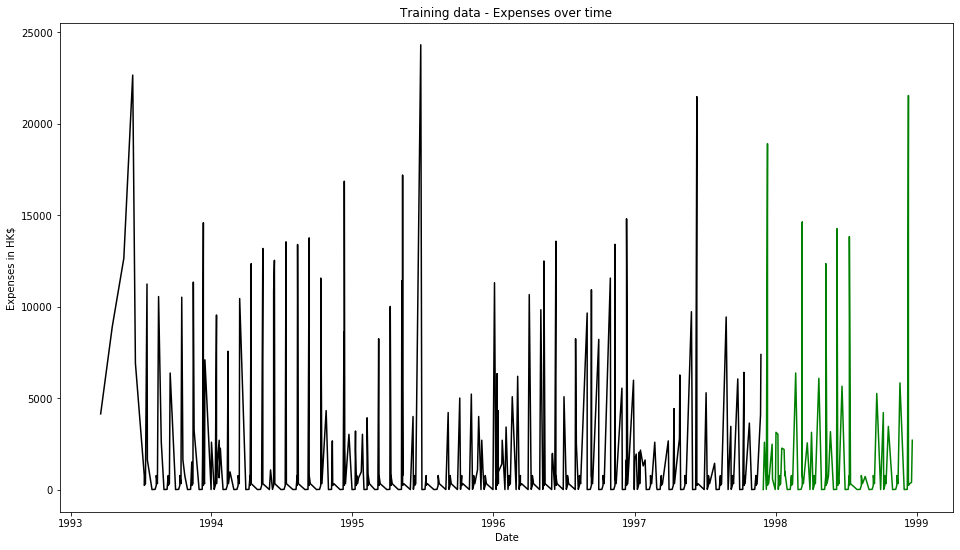

In [12]:
plt.figure(figsize=(16, 9))
plt.title('Training data - Expenses over time')
visual = df[df['account_id']==96].fillna(0)
visual.index = visual['date']
plt.plot(visual['amount'][:split], color='black')
plt.plot(visual['amount'][split:], color='green')
plt.xlabel('Date')
plt.ylabel('Expenses in HK$')
plt.savefig('predictions/96.png')
plt.show()

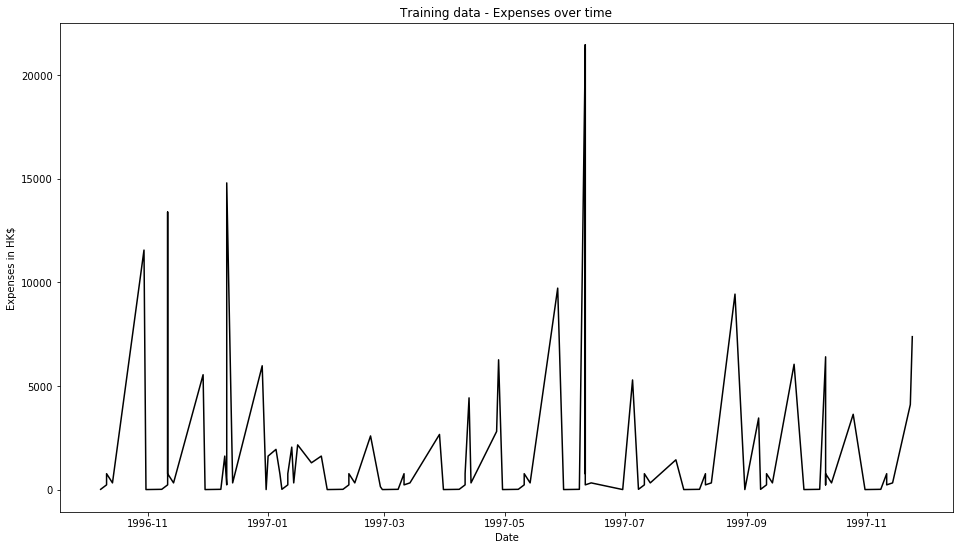

In [13]:
plt.figure(figsize=(16, 9))
plt.title('Training data - Expenses over time')
visual = df[df['account_id']==96].fillna(0)
visual.index = visual['date']
plt.plot(visual['amount'][split-100:split], color='black')
# plt.plot(visual['amount'][split:], color='green')
plt.xlabel('Date')
plt.ylabel('Expenses in HK$')
plt.savefig('predictions/96-2.png')
plt.show()

In [14]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_np.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.summary()

2023-03-30 06:14:51.876832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
lstm_model.fit(x_train_np, y_train_np, batch_size=1, epochs=100, verbose=1)

Epoch 1/100
383/383 [==============================] - 4s 6ms/step - loss: 0.0302
Epoch 2/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0290
Epoch 3/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0288
Epoch 4/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0289
Epoch 5/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0287
Epoch 6/100
383/383 [==============================] - 3s 7ms/step - loss: 0.0287
Epoch 7/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0285
Epoch 8/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0289
Epoch 9/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0285
Epoch 10/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0287
Epoch 11/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0286
Epoch 12/100
383/383 [==============================] - 3s 8ms/step - loss: 0.0286
Epoch 13/100


383/383 [==============================] - 2s 6ms/step - loss: 0.0266
Epoch 100/100
383/383 [==============================] - 2s 6ms/step - loss: 0.0256


In [16]:
y_predicted = lstm_model.predict(x_test_np)
# print(y_predicted)
print(y_predicted.shape)
y_predicted = scaler.inverse_transform(y_predicted)

(96, 1)


In [ ]:
x_test_

In [17]:
y_test_transformed = scaler.inverse_transform(y_test_np)
print('Validation Root Mean Square Error (RMSE):', np.sqrt(mean_squared_error(y_test_transformed, y_predicted)))

Validation Root Mean Square Error (RMSE): 3961.2704634618963


In [19]:
validation = y_s.filter(['amount'])
validation['Prediction'] = y_predicted
validation

,amount,Prediction
383,5.256,1469.744019
384,2592.000,1564.825439
385,16.560,2986.762207
386,18900.000,1831.535522
387,231.840,641.514832
...,...,...
474,770.400,1181.290649
475,231.840,1178.907715
476,326.880,1471.291382
477,396.000,1301.229004


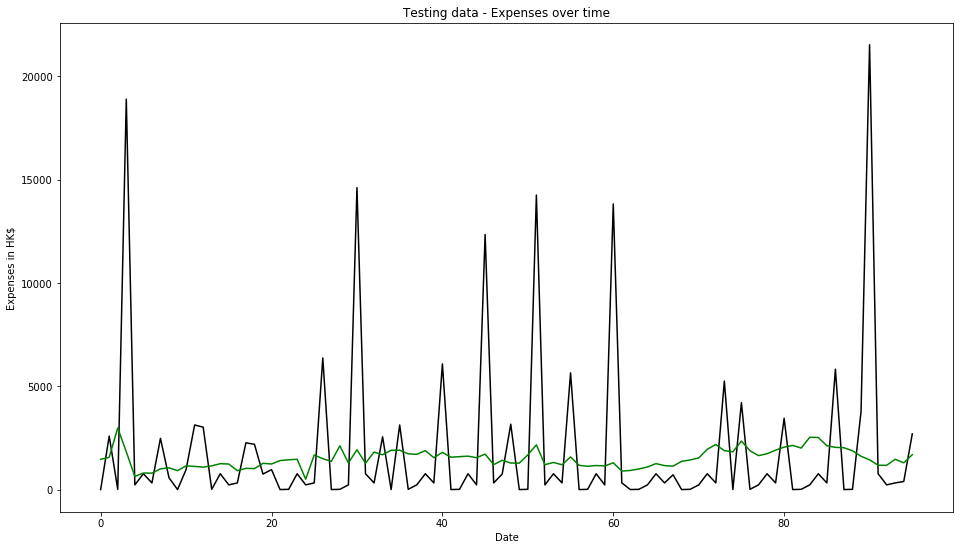

In [22]:
actual = test.reset_index()
plt.figure(figsize=(16, 9))
plt.title('Testing data - Expenses over time')
plt.plot(actual['amount'], color='black')
plt.plot(y_predicted, color='green')
plt.xlabel('Date')
plt.ylabel('Expenses in HK$')
plt.savefig('predictions/96-pred.png')
plt.show()

In [31]:
test

,index,trans_id,account_id,type,amount,last_trans_1,last_trans_2,last_trans_3,last_trans_4,last_trans_5,...,last_trans_15,last_trans_16,last_trans_17,last_trans_18,last_trans_19,last_trans_20,weekday,day,month,year
383,13560,29714,96,1,5.256,5.256,7380.000,4104.000,326.880,231.840,...,5.256,6048.000,326.880,770.400,231.840,16.560,6,30,11,1997
384,13561,29587,96,1,2592.000,2592.000,5.256,7380.000,4104.000,326.880,...,16.560,5.256,6048.000,326.880,770.400,231.840,2,3,12,1997
385,13562,29455,96,1,16.560,16.560,2592.000,5.256,7380.000,4104.000,...,6408.000,16.560,5.256,6048.000,326.880,770.400,0,8,12,1997
386,13563,29798,96,1,18900.000,18900.000,16.560,2592.000,5.256,7380.000,...,231.840,6408.000,16.560,5.256,6048.000,326.880,3,11,12,1997
387,13564,29527,96,1,231.840,231.840,18900.000,16.560,2592.000,5.256,...,770.400,231.840,6408.000,16.560,5.256,6048.000,3,11,12,1997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,13651,29395,96,1,770.400,770.400,21528.000,3780.000,16.560,5.256,...,231.840,16.560,4212.000,5.256,5256.000,326.880,4,11,12,1998
475,13652,29539,96,1,231.840,231.840,770.400,21528.000,3780.000,16.560,...,770.400,231.840,16.560,4212.000,5.256,5256.000,4,11,12,1998
476,13653,29323,96,1,326.880,326.880,231.840,770.400,21528.000,3780.000,...,326.880,770.400,231.840,16.560,4212.000,5.256,0,14,12,1998
477,13654,29815,96,1,396.000,396.000,326.880,231.840,770.400,21528.000,...,3456.000,326.880,770.400,231.840,16.560,4212.000,5,19,12,1998


In [45]:
test.iloc[1]

index            13561.000
trans_id         29587.000
account_id          96.000
type                 1.000
amount            2592.000
last_trans_1      2592.000
last_trans_2         5.256
last_trans_3      7380.000
last_trans_4      4104.000
last_trans_5       326.880
last_trans_6       231.840
last_trans_7       770.400
last_trans_8        16.560
last_trans_9         5.256
last_trans_10     3636.000
last_trans_11      326.880
last_trans_12      770.400
last_trans_13      231.840
last_trans_14     6408.000
last_trans_15       16.560
last_trans_16        5.256
last_trans_17     6048.000
last_trans_18      326.880
last_trans_19      770.400
last_trans_20      231.840
weekday              2.000
day                  3.000
month               12.000
year              1997.000
Name: 384, dtype: float64

In [33]:
import joblib

joblib.dump(lstm_model, 'lstm_model.pkl')
lr = joblib.load('lstm_model.pkl')
lstm_columns = list(x_t.columns)
joblib.dump(lstm_columns, 'lstm_columns.pkl')

2023-03-29 22:37:20.735864: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://99bbd352-c036-4696-a19d-f93a4a035a9a/assets


INFO:tensorflow:Assets written to: ram://99bbd352-c036-4696-a19d-f93a4a035a9a/assets


['lstm_columns.pkl']